In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
df = pd.read_csv('ETH_USD_15Min.csv')
df.head()

,t,close,high,low,trade_count,open,volume,vwap
0,2021-01-01 06:00:00+00:00,743.69,744.61,742.15,17,742.15,5.16296,743.562012
1,2021-01-01 06:15:00+00:00,739.25,743.91,738.16,47,743.69,39.01128,740.034009
2,2021-01-01 06:30:00+00:00,741.00,741.48,738.64,50,739.21,82.11928,740.671763
3,2021-01-01 06:45:00+00:00,741.06,741.41,739.85,16,741.25,21.99636,741.118902
4,2021-01-01 07:00:00+00:00,737.34,741.86,736.11,52,741.41,95.07717,738.790665


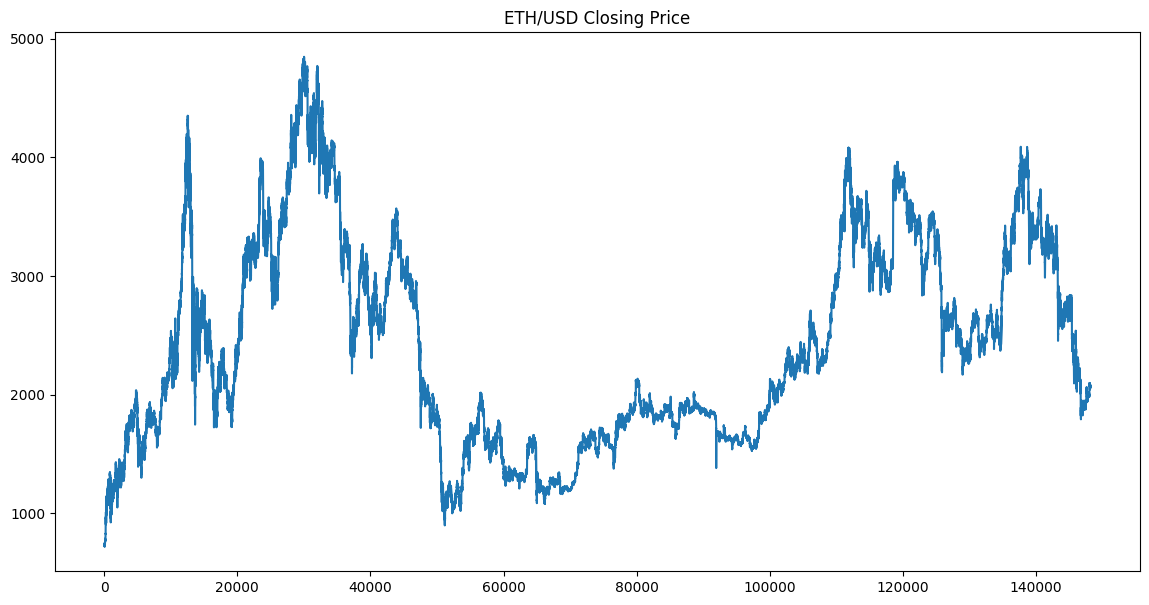

In [5]:
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['close'], label='ETH/USD Closing Price')
plt.title('ETH/USD Closing Price')
plt.show()

In [9]:
def calculate_indicators(df):
    # RSI 14
    delta = df['close'].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    avg_gain = pd.Series(gain).rolling(window=14).mean()
    avg_loss = pd.Series(loss).rolling(window=14).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    df['RSI'] = rsi

    # MACD
    ema_12 = df['close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['close'].ewm(span=26, adjust=False).mean()
    macd_line = ema_12 - ema_26
    signal_line = macd_line.ewm(span=9, adjust=False).mean()
    histogram = macd_line - signal_line

    df['MACD'] = macd_line
    df['Signal_Line'] = signal_line
    df['Histogram'] = histogram

    return df

df = calculate_indicators(df)
df.tail()


,t,close,high,low,trade_count,open,volume,vwap,RSI,MACD,Signal_Line,Histogram
148196,2025-03-26 00:30:00+00:00,2075.645,2076.273,2067.0480,0,2070.2850,0.000000,2070.2850,54.681972,-0.160794,-1.105359,0.944565
148197,2025-03-26 00:45:00+00:00,2070.998,2077.134,2070.3235,1,2074.6380,0.023246,2077.1340,48.254108,0.119532,-0.860381,0.979912
148198,2025-03-26 01:00:00+00:00,2070.255,2070.401,2066.8650,0,2070.4010,0.000000,2070.4010,55.314497,0.278527,-0.632599,0.911126
148199,2025-03-26 01:15:00+00:00,2075.750,2077.300,2069.3255,1,2069.3255,0.006491,2077.3000,62.009202,0.838269,-0.338426,1.176695
148200,2025-03-26 01:30:00+00:00,2077.075,2079.460,2074.0760,12,2076.7585,0.057554,2078.2083,59.848766,1.372959,0.003851,1.369107


## Strategy Logic

Buy when:
    RSI(14) < 30
    MACD Hist is NOT showing persistant bearish momentum

Sell when:
    RSI(14) < 70

In [10]:
def backtest_strategy(df, macd_filter_window=25):
    in_position = False
    buy_price = 0
    trades = []

    for i in range(macd_filter_window, len(df)):
        rsi = df['RSI'].iloc[i]
        macd_line = df['MACD'].iloc[i]
        signal_line = df['Signal_Line'].iloc[i]
        macd_hist_window = df['Histogram'].iloc[i-macd_filter_window:i]

        # Check MACD momentum filter: if MACD_Hist consistently < 0, don't trade
        bearish_trend = (macd_hist_window < 0).all()

        if not in_position:
            if rsi < 30 and not bearish_trend:
                buy_price = df['close'].iloc[i]
                in_position = True
                trades.append({'type': 'buy', 'price': buy_price, 'time': df.index[i]})
        else:
            if rsi > 70:
                sell_price = df['close'].iloc[i]
                in_position = False
                trades.append({'type': 'sell', 'price': sell_price, 'time': df.index[i]})

    return trades

trades = backtest_strategy(df)

In [12]:
for t in trades:
    print(t)

{'type': 'buy', 'price': 735.07, 'time': 45}
{'type': 'sell', 'price': 731.76, 'time': 64}
{'type': 'buy', 'price': 719.83, 'time': 73}
{'type': 'sell', 'price': 732.0, 'time': 90}
{'type': 'buy', 'price': 970.0, 'time': 303}
{'type': 'sell', 'price': 994.94, 'time': 318}
{'type': 'buy', 'price': 993.54, 'time': 376}
{'type': 'sell', 'price': 1045.9, 'time': 397}
{'type': 'buy', 'price': 1084.23, 'time': 464}
{'type': 'sell', 'price': 1132.88, 'time': 473}
{'type': 'buy', 'price': 1188.3, 'time': 584}
{'type': 'sell', 'price': 1228.99, 'time': 603}
{'type': 'buy', 'price': 1214.47, 'time': 650}
{'type': 'sell', 'price': 1150.42, 'time': 672}
{'type': 'buy', 'price': 1208.81, 'time': 710}
{'type': 'sell', 'price': 1223.17, 'time': 744}
{'type': 'buy', 'price': 1180.94, 'time': 771}
{'type': 'sell', 'price': 1229.76, 'time': 785}
{'type': 'buy', 'price': 1282.03, 'time': 885}
{'type': 'sell', 'price': 1308.31, 'time': 901}
{'type': 'buy', 'price': 1229.95, 'time': 920}
{'type': 'sell', '

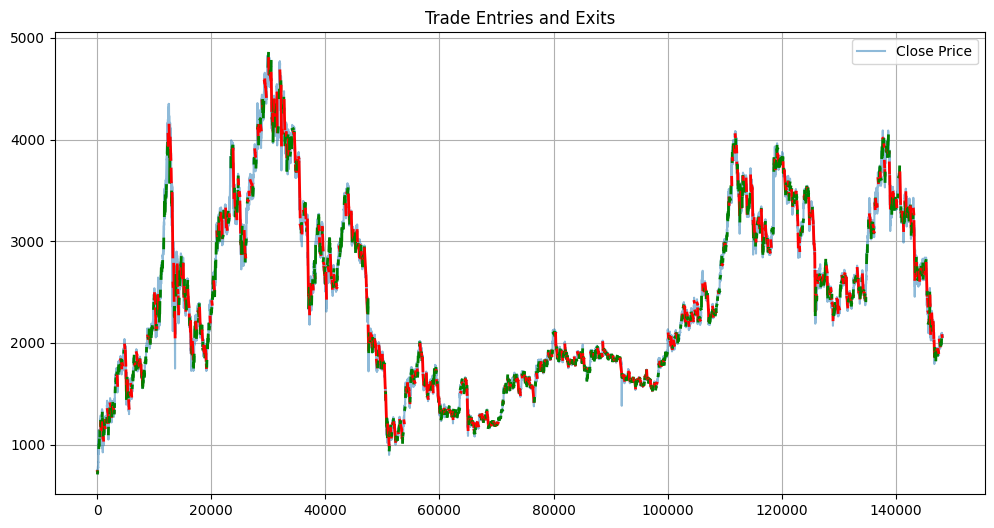

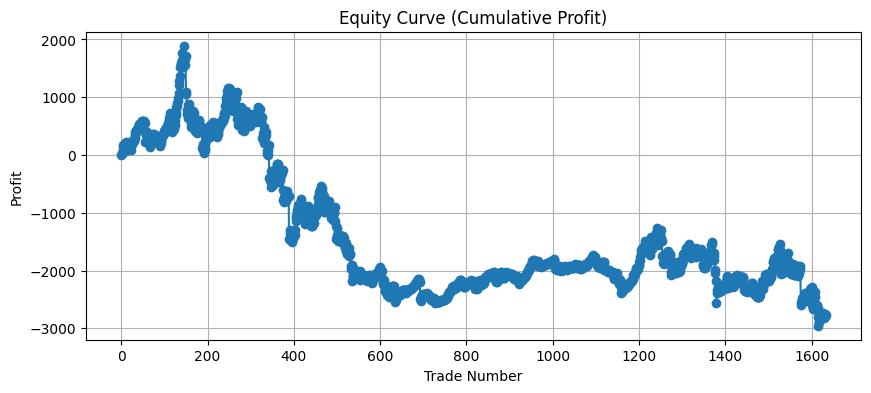

In [13]:
# Profit Analysis
pnl = []
positions = []
for i in range(1, len(trades), 2):  # Every buy/sell pair
    if trades[i]['type'] == 'sell' and trades[i-1]['type'] == 'buy':
        profit = trades[i]['price'] - trades[i-1]['price']
        pnl.append(profit)
        positions.append((trades[i-1]['time'], trades[i]['time'], trades[i-1]['price'], trades[i]['price']))

# Equity curve
equity = np.cumsum(pnl)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df['close'], label='Close Price', alpha=0.5)
for entry, exit, buy, sell in positions:
    plt.plot([entry, exit], [buy, sell], color='green' if sell > buy else 'red', linewidth=2)
plt.title('Trade Entries and Exits')
plt.legend()
plt.grid(True)
plt.show()

# Plot equity curve
plt.figure(figsize=(10, 4))
plt.plot(equity, marker='o')
plt.title('Equity Curve (Cumulative Profit)')
plt.xlabel('Trade Number')
plt.ylabel('Profit')
plt.grid(True)
plt.show()